# Web Visualizer Process

---

## 1. Import Modules

In [1]:
import os
from config.secret_keys import OPENAI_API_KEY, USER_AGENT, TAVILY_API_KEY

os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY
os.environ['USER_AGENT'] = USER_AGENT

In [2]:
from pathlib import Path

BASE_DIR = Path(os.getcwd())
DATA_DIR = BASE_DIR / 'data' # 데이터 저장용 디렉토리
CHART_DIR = BASE_DIR / 'charts' # 차트 저장용 디엑토리

## 2. Import Modules

In [3]:
# Define State
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

# Define Tools
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.utilities import PythonREPL
from langchain_core.tools import tool
# import pandas as pd
# from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
# from langchain.agents.agent_types import AgentType

# Define Agent
from langchain_openai import ChatOpenAI

# Define Node
from langgraph.prebuilt import ToolNode

# Define Edges
from langgraph.prebuilt import tools_condition
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Prompts
from langchain_core.messages import SystemMessage, HumanMessage

## 3. Build Application

### 3-1. Define State

In [4]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

### 3-1. Define Tools

In [5]:
# web search tool
web_search_tool = TavilySearchResults(max_results=3)

doc_string_template = """
    Use this tool to execute Python code and generate the desired results.

    Write Python code that generates a graph and saves the graph image in the './charts/{session_id}/' folder.

    If the specified folder does not exist, create the folder at the given path.

    Follow the requirements below to write the code:

    1. Save the generated graph image in the './charts/{session_id}/' folder.
    2. The image format should be PNG.
    3. chart labels should be written in English.
    4. Ensure proper cleanup of resources used by Matplotlib to prevent memory leaks.
    
    The result should be fully functional Python code. Add comments to explain each step of the code.
"""

# python code interpreter
repl = PythonREPL()
# @tool
def python_repl(
    code : Annotated[str, "The Python code to execute to generate your chart."]
):
    
    # """
    # Use this to execute python code.

    # If you want to see the output of a value, you should print it out with 'print(...)'. chart labels should be written in English.

    # This is visible to the user.

    # Please make the chart and save in './charts' folder.
    # """

    try : 
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error : {repr(e)}"
    
    result_str = f"Successfully executed: \n```python\n{code}\n```Stdout: {result}"

    return (
        result_str + "\n\nIf you have completed all tasks, repond with FINAL ANSWER."
    )

session_id = "skn-02"
python_repl.__doc__ = doc_string_template.format(session_id=session_id)
print(python_repl.__doc__)

python_repl_tool = tool(python_repl)

tools = [web_search_tool, python_repl_tool]


    Use this tool to execute Python code and generate the desired results.

    Write Python code that generates a graph and saves the graph image in the './charts/skn-02/' folder.

    If the specified folder does not exist, create the folder at the given path.

    Follow the requirements below to write the code:

    1. Save the generated graph image in the './charts/skn-02/' folder.
    2. The image format should be PNG.
    3. chart labels should be written in English.
    4. Ensure proper cleanup of resources used by Matplotlib to prevent memory leaks.
    
    The result should be fully functional Python code. Add comments to explain each step of the code.



### 3-2. Define Agent

In [6]:
llm = ChatOpenAI(
    model = "gpt-4o"
)
llm_with_tools = llm.bind_tools(tools)

### 3-3. Define Nodes

In [7]:
def web_visualizer_node(state):
    result = llm_with_tools.invoke(state["messages"])
    return {'messages' : [result]}

tool_node = ToolNode(tools)

### 3-4. Define Conditional Edge Function

In [8]:
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    print("="*100)
    print(last_message)
    print("="*100)
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"

### 3-5. Build Graph

In [9]:
workflow = StateGraph(State)
memory = MemorySaver()

workflow.add_node("web_visualizer", web_visualizer_node)
workflow.add_node("tool", tool_node)

workflow.add_edge(START, "web_visualizer")

workflow.add_conditional_edges(
    "web_visualizer",
    should_continue,
    {
        "continue" : "tool",
        "end" : END
    }
)

workflow.add_edge("tool", "web_visualizer")

app = workflow.compile(checkpointer=memory)

## 4. Visualize Graph

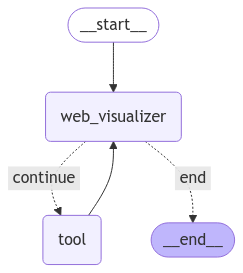

In [10]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
initial_input = {'messages' : [HumanMessage(content="최근 엔비디아의 주가 정보 동향에 대해 시각화 해줄래?")]}
thread = {"configurable" : {"thread_id" : "3"}}

for chunk in app.stream(initial_input, thread, stream_mode="updates"): # update 된 state 값만 가져옴져옴
    for node, values in chunk.items():
        print(f"Receving update from node: '{node}")
        print(values)
        print("\n\n")

content='' additional_kwargs={'tool_calls': [{'id': 'call_TuqiZdcUUCksIKhv9p8Q8gqi', 'function': {'arguments': '{"query":"NVIDIA stock price trend October 2023"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 262, 'total_tokens': 289, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_4691090a87', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-19159758-d215-4494-8076-9e70ee0c44db-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'NVIDIA stock price trend October 2023'}, 'id': 'call_TuqiZdcUUCksIKhv9p8Q8gqi', 'type': 'tool_call'}] usage_metadata={'input_tokens': 262, 'output_tokens': 27, 'total_tokens': 289, 'input_token_details': {'au

Python REPL can execute arbitrary code. Use with caution.


content='' additional_kwargs={'tool_calls': [{'id': 'call_evAYSdKmx2vrgcyaauSxX5mg', 'function': {'arguments': '{"code":"import matplotlib.pyplot as plt\\nimport matplotlib.dates as mdates\\nfrom datetime import datetime\\n\\n# NVIDIA stock prices for October 2023\\n# Assuming some sample data for the month\\n# Prices are illustrative and not actual\\nprices = [150, 145, 148, 147, 145, 140, 138, 135, 137, 140, 142, 141, 143, 145, 146, 147, 145, 142, 140, 138, 136, 134, 135, 136, 138, 137, 138, 139, 140, 138, 138.81]\\ndates = [datetime(2023, 10, day) for day in range(1, 32)]\\n\\n# Create a plot\\nfig, ax = plt.subplots(figsize=(10, 6))\\nax.plot(dates, prices, marker=\'o\', linestyle=\'-\')\\n\\n# Format the x-axis for dates\\nax.xaxis.set_major_formatter(mdates.DateFormatter(\'%Y-%m-%d\'))\\nax.xaxis.set_major_locator(mdates.DayLocator(interval=2))\\nplt.xticks(rotation=45)\\n\\n# Adding labels and title\\nplt.title(\'NVIDIA Stock Price Trend October 2023\')\\nplt.xlabel(\'Date\')\\n